In [86]:
import numpy as np
import pandas as pd

from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 
from dotenv import load_dotenv
import panel as pn
import plotly.express as px
import hvplot.pandas
import hvplot

pn.extension("plotly")

%matplotlib inline

In [87]:
load_dotenv()

alpaca_api_key = os.getenv("Api_key")
alpaca_secret_key = os.getenv("Secret_key")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


type(alpaca_secret_key)

str

In [88]:
sp500_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')


In [89]:
sp500_df.head()

1. open   2. high    3. low  4. close  5. adjusted close  \
date                                                                    
2000-07-03  145.4375  147.4375  145.1875  147.2812           100.6579   
2000-07-05  146.3750  146.6562  144.3750  144.6250            98.8425   
2000-07-06  144.9375  146.4687  144.2187  145.7500            99.6114   
2000-07-07  146.6875  148.7812  146.2500  148.0937           101.2132   
2000-07-10  147.8750  148.9062  147.5312  147.8437           101.0423   

            6. volume  7. dividend amount  8. split coefficient  
date                                                             
2000-07-03  1436600.0                 0.0                   1.0  
2000-07-05  2748200.0                 0.0                   1.0  
2000-07-06  5963200.0                 0.0                   1.0  
2000-07-07  3034800.0                 0.0                   1.0  
2000-07-10  2816100.0                 0.0                   1.0

In [90]:
sp500_df.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. adjusted close',
       '6. volume', '7. dividend amount', '8. split coefficient'],
      dtype='object')

In [91]:
sp500_df.drop(columns=['5. adjusted close','7. dividend amount', '8. split coefficient'], inplace=True)
sp500_df.sort_index(inplace=True, ascending=True)
sp500_df.head()

1. open   2. high    3. low  4. close  6. volume
date                                                         
2000-07-03  145.4375  147.4375  145.1875  147.2812  1436600.0
2000-07-05  146.3750  146.6562  144.3750  144.6250  2748200.0
2000-07-06  144.9375  146.4687  144.2187  145.7500  5963200.0
2000-07-07  146.6875  148.7812  146.2500  148.0937  3034800.0
2000-07-10  147.8750  148.9062  147.5312  147.8437  2816100.0

In [92]:
sp500_df['daily_return'] = sp500_df['4. close'].dropna().pct_change()
sp500_df.head()

1. open   2. high    3. low  4. close  6. volume  daily_return
date                                                                       
2000-07-03  145.4375  147.4375  145.1875  147.2812  1436600.0           NaN
2000-07-05  146.3750  146.6562  144.3750  144.6250  2748200.0     -0.018035
2000-07-06  144.9375  146.4687  144.2187  145.7500  5963200.0      0.007779
2000-07-07  146.6875  148.7812  146.2500  148.0937  3034800.0      0.016080
2000-07-10  147.8750  148.9062  147.5312  147.8437  2816100.0     -0.001688

In [126]:
bollinger_window = 1
bollinger_window_long = 11

# Calculate rolling mean and standard deviation
sp500_df['bollinger_mid_band'] = sp500_df['4. close'].rolling(window=bollinger_window).mean()
sp500_df['bollinger_lond_band']= sp500_df['4. close'].rolling(window= bollinger_window_long).mean()
sp500_df['bollinger_std'] = sp500_df['4. close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
sp500_df['bollinger_upper_band']  = sp500_df['bollinger_mid_band'] + (sp500_df['bollinger_std'] * 1.5)
sp500_df['bollinger_lower_band']  = sp500_df['bollinger_mid_band'] - (sp500_df['bollinger_std'] * 1.5)

# Calculate bollinger band trading signal
sp500_df['bollinger_long'] = np.where(sp500_df['4. close'] < sp500_df['bollinger_lower_band'], 1.0, 0.0)
sp500_df['bollinger_short'] = np.where(sp500_df['4. close'] > sp500_df['bollinger_upper_band'], -1.0, 0.0)
sp500_df['bollinger_signal'] = sp500_df['bollinger_long'] + sp500_df['bollinger_short']


sp500_df.head(10)

date   1. open   2. high    3. low  4. close  6. volume  daily_return  \
0 2000-07-03  145.4375  147.4375  145.1875  147.2812  1436600.0           NaN   
1 2000-07-05  146.3750  146.6562  144.3750  144.6250  2748200.0     -0.018035   
2 2000-07-06  144.9375  146.4687  144.2187  145.7500  5963200.0      0.007779   
3 2000-07-07  146.6875  148.7812  146.2500  148.0937  3034800.0      0.016080   
4 2000-07-10  147.8750  148.9062  147.5312  147.8437  2816100.0     -0.001688   
5 2000-07-11  147.4687  149.1250  147.1562  148.1562  5431600.0      0.002114   
6 2000-07-12  149.2812  150.1250  148.6875  149.1250  5883000.0      0.006539   
7 2000-07-13  149.9843  150.3750  149.1875  149.7812  5356000.0      0.004400   
8 2000-07-14  150.4375  151.2500  149.6718  151.2500  5341900.0      0.009806   
9 2000-07-17  150.9843  151.9843  150.6875  151.0000  4208300.0     -0.001653   

   bollinger_mid_band  bollinger_lond_band  bollinger_std  \
0            147.2812                  NaN            NaN   
1            144.6250                  NaN            NaN   
2            145.7500                  NaN            NaN   
3            148.0937                  NaN            NaN   
4            147.8437                  NaN            NaN   
5            148.1562                  NaN            NaN   
6            149.1250                  NaN            NaN   
7            149.7812                  NaN            NaN   
8            151.2500                  NaN            NaN   
9            151.0000                  NaN            NaN   

   bollinger_upper_band  bollinger_lower_band  bollinger_long  \
0                   NaN                   NaN             0.0   
1                   NaN                   NaN             0.0   
2                   NaN                   NaN             0.0   
3                   NaN                   NaN             0.0   
4                   NaN                   NaN             0.0   
5                   NaN                   NaN             0.0   
6                   NaN                   NaN             0.0   
7                   NaN                   NaN             0.0   
8                   NaN                   NaN             0.0   
9                   NaN                   NaN             0.0   

   bollinger_short  bollinger_signal  
0              0.0               0.0  
1              0.0               0.0  
2              0.0               0.0  
3              0.0               0.0  
4              0.0               0.0  
5              0.0               0.0  
6              0.0               0.0  
7              0.0               0.0  
8              0.0               0.0  
9              0.0               0.0

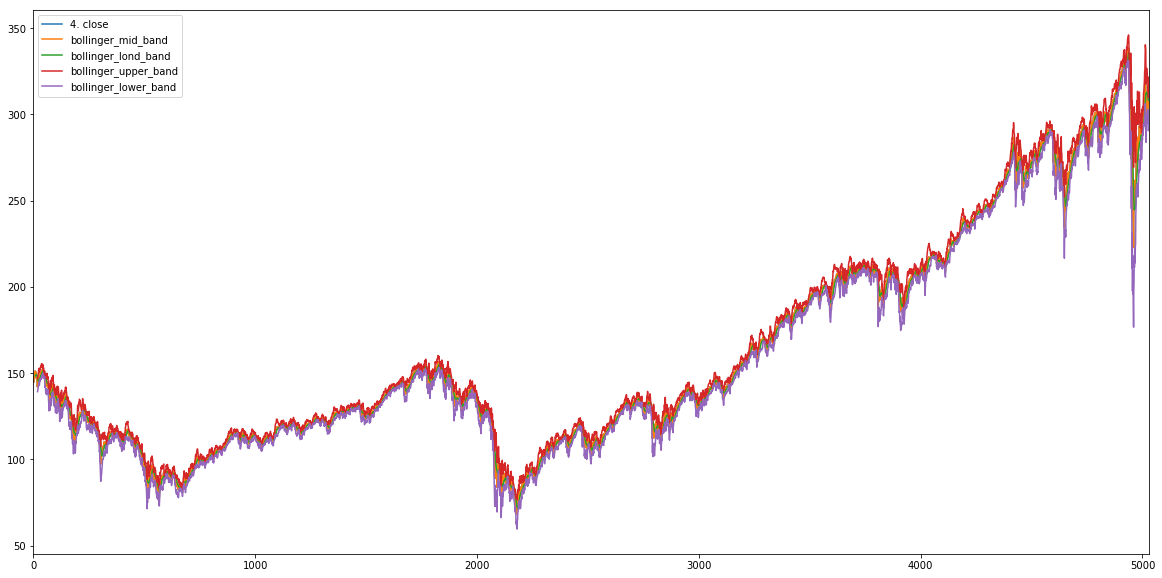

In [127]:
sp500_df[['4. close','bollinger_mid_band','bollinger_lond_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [128]:
sp500= sp500_df[['4. close','bollinger_mid_band','bollinger_lond_band','bollinger_upper_band','bollinger_lower_band']]
sp500.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [125]:
sp500.reset_index(level="date",inplace=True)
sp500.head()

KeyError: 'Level date must be same as name (None)'

In [106]:
import plotly.graph_objects as go
import pandas as pd

fig = px.line(sp500, x='date', y=['4. close','bollinger_mid_band', 'bollinger_lond_band','bollinger_upper_band','bollinger_lower_band'], 
              title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig